## Calculating asymmetry index of brain regions 
Črt Rozman <br>
September 2024 <br>
In this file I try to calculate the AI using already written matlab code by Eva Štokelj and Ali Deatsch.

### Importing libraries

In [2]:
# Import necessary libraries

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import label as bwlabeln

save_path = "./results"

### Importing data
A nifti file is made up of a .img file and a .hdr file. We want to isolate .img file.

In [3]:
# Define the directories for the images and masks
ad_fdgpet_dir = 'C:/Users/Crt/Desktop/WIMR/asymmetryAD/UW_data/AD_FDGPET_preprocessed'
nc_fdgpet_dir = 'C:/Users/Crt/Desktop/WIMR/asymmetryAD/UW_data/NC_FDGPET_preprocessed'

ad_mri_dir = 'C:/Users/Crt/Desktop/WIMR/asymmetryAD/UW_data/AD_MRIT1_mprage_preprocessed'
nc_mri_dir = 'C:/Users/Crt/Desktop/WIMR/asymmetryAD/UW_data/NC_MRIT1_mprage_preprocessed'


mask_dir = 'C:/Users/Crt/Desktop/WIMR/asymmetryAD/UW_data/AAL3+pons'

# Get list of all .nii files in the directory
list_nii = [os.path.join(ad_fdgpet_dir, f) for f in os.listdir(ad_fdgpet_dir) if f.endswith('.nii')]

# Get list of all .img mask files
mask_files = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.nii')]


In [4]:
print(len(list_nii))
print(len(mask_files))

364
1


### Visualizing data
Just a quick look at the data I am dealing with. I will visualize two examples, one for FDGPET and one for MRI scan.<br>
Shape of images is (91, 109, 91).

In [5]:
fdgpet_example_path = 'C:/Users/Crt/Desktop/WIMR/asymmetryAD/UW_data/AD_FDGPET_preprocessed/Inf_NaN_stableAD__I11767_masked_brain.nii.nii'  
mri_example_path = 'C:/Users/Crt/Desktop/WIMR/asymmetryAD/UW_data/AD_MRIT1_mprage_preprocessed/bet_crf_rsl_NaN_Inf_rstableAD__I10146_masked_brain.nii.nii' 

fdgpet_example_image = nib.load(fdgpet_example_path)
mri_example_image = nib.load(mri_example_path)

# Get the image data from the NIfTI file
fdgpet_example_img_data = fdgpet_example_image.get_fdata()
mri_example_img_data = mri_example_image.get_fdata()

print(fdgpet_example_img_data.shape)
print(mri_example_img_data.shape)

(91, 109, 91)
(91, 109, 91)


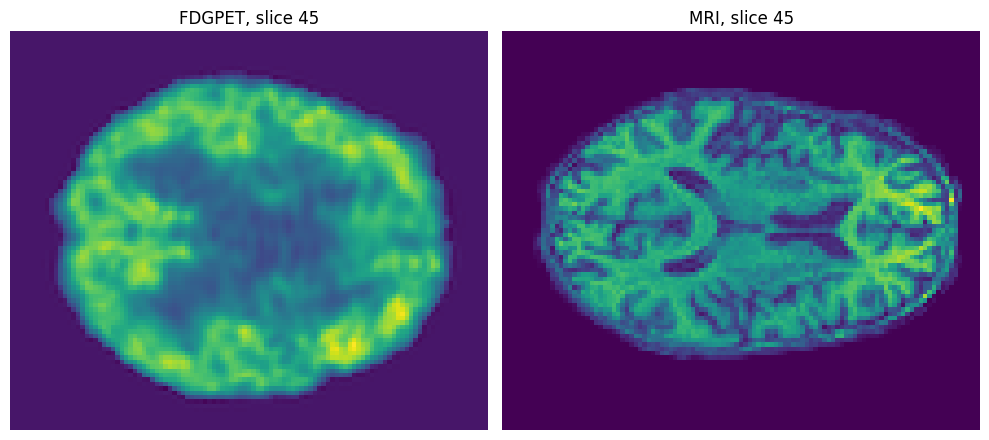

In [6]:
# Visualize slices of FDGPET and MRI images side by side
fdgpet_slice_index = fdgpet_example_img_data.shape[2] // 2  # Middle slice for FDGPET
mri_slice_index = mri_example_img_data.shape[2] // 2        # Middle slice for MRI

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(fdgpet_example_img_data[:, :, fdgpet_slice_index])
axs[0].set_title(f'FDGPET, slice {fdgpet_slice_index}')
axs[0].axis('off')

axs[1].imshow(mri_example_img_data[:, :, mri_slice_index])
axs[1].set_title(f'MRI, slice {mri_slice_index}')
axs[1].axis('off')

plt.tight_layout()
plt.show()

### Animating slices
Thought it would be interesting to animate iteration throught each slice for both methods

In [7]:
import matplotlib.animation as animation

In [8]:
# def get_animation():

#     def iteration(i):

#         plt.suptitle(f"Slice {i}")

#         axs[0].imshow(fdgpet_example_img_data[:, :, i])
#         axs[0].set_title(f'FDGPET')
#         axs[0].axis('off')

#         axs[1].imshow(mri_example_img_data[:, :, i])
#         axs[1].set_title(f'MRI')
#         axs[1].axis('off')

#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#     plt.tight_layout()

#     ani = animation.FuncAnimation(fig, iteration, [i for i in range(0, fdgpet_example_img_data.shape[2])], interval=10)
#     ani.save(save_path + "/slices_animation.gif")
    

In [9]:
# get_animation()

### Mask
Let's take a look at how the mask files are structured.

In [10]:
# Read the text file that contains mask names
mask_txt_file = 'C:/Users/Crt/Desktop/WIMR/asymmetryAD/UW_data/AAL3+pons/AAL3+Pons.txt'

# Open and read the mask title file
masks_title = []
with open(mask_txt_file, 'r') as f:
    for line in f:
        parts = line.split()                        # Split the line by whitespace
        if len(parts) > 1:                          # Avoid lines that are too short
            masks_title.append(parts[1])            # Take the second column (like data{1, 2} in MATLAB)

# we
masks_title_all = masks_title[:-1]                   # all masks, containing both L and R hemispheres
masks_title_L = masks_title[:-1:2]                   # left side
masks_title_R = masks_title[1::2]                    # right side


I excluded the last element named "pons", since it's not paired with any other region.

In [11]:
print(masks_title_all)
print(masks_title_L)
print(masks_title_R)

['Precentral_L', 'Precentral_R', 'Frontal_Sup_2_L', 'Frontal_Sup_2_R', 'Frontal_Mid_2_L', 'Frontal_Mid_2_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_2_L', 'Frontal_Inf_Orb_2_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'OFCmed_L', 'OFCmed_R', 'OFCant_L', 'OFCant_R', 'OFCpost_L', 'OFCpost_R', 'OFClat_L', 'OFClat_R', 'Insula_L', 'Insula_R', 'Cingulate_Ant_L', 'Cingulate_Ant_R', 'Cingulate_Mid_L', 'Cingulate_Mid_R', 'Cingulate_Post_L', 'Cingulate_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_L', 'Occipital_Inf_R',

In [12]:
print(len(masks_title_all))
print(len(masks_title_L))
print(len(masks_title_R))

170
85
85


Now the mask stored in .nii file.

In [13]:
mask_path = 'C:/Users/Crt/Desktop/WIMR/asymmetryAD/UW_data/AAL3+pons/AAL3+pons.nii' 

mask_image = nib.load(mask_path)

mask_image_data = mask_image.get_fdata()

In [14]:
print(mask_image_data.shape)

(91, 109, 91)


Visualizing the mask.

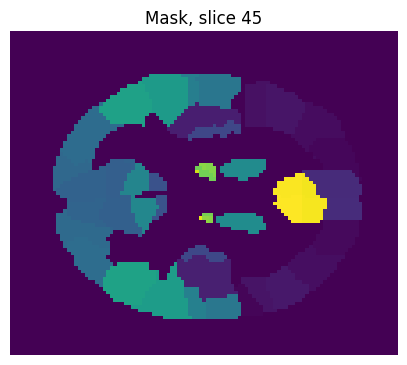

In [15]:
mask_slice_index = fdgpet_example_img_data.shape[2] // 2  # middle slice

fig = plt.figure(figsize=(5, 5))

plt.imshow(mask_image_data[:, :, mask_slice_index])  
plt.title(f'Mask, slice {mask_slice_index}')
plt.axis('off')

plt.show()

Animating different slices of mask.

In [16]:
# def get_animation():

#     def iteration(i):

#         plt.title(f"Mask, slice {i}")
#         plt.imshow(mask_image_data[:, :, i])
#         plt.axis('off')

#     fig = plt.figure(figsize=(5, 5))

#     ani = animation.FuncAnimation(fig, iteration, [i for i in range(0, mask_image_data.shape[2])], interval=10)
#     ani.save(save_path + "/mask_slices_animation.gif")

In [17]:
# get_animation()

### Arranging AD and NC patients
I will make a new array that stores .nii files of both AD and NC patients (in that order). <br>
For now I will work with 50 patients from each grou to speed up the calculations.

In [18]:
# index where we cut the data
idx = 50

# Empty array to store all .nii files of both AD and NC patients
list_nii_arranged = []

list_nii_arranged.extend([os.path.join(ad_mri_dir, f) for f in os.listdir(ad_mri_dir) if f.endswith('.nii')])
list_nii_arranged = list_nii_arranged[0:idx]

list_nii_arranged.extend([os.path.join(nc_mri_dir, f) for f in os.listdir(nc_mri_dir) if f.endswith('.nii')])
list_nii_arranged = list_nii_arranged[0:2*idx]

In [19]:
print(list_nii_arranged)
print(len(list_nii_arranged))

['C:/Users/Crt/Desktop/WIMR/asymmetryAD/UW_data/AD_MRIT1_mprage_preprocessed\\bet_crf_rsl_NaN_Inf_rstableAD_I102672_masked_brain.nii.nii', 'C:/Users/Crt/Desktop/WIMR/asymmetryAD/UW_data/AD_MRIT1_mprage_preprocessed\\bet_crf_rsl_NaN_Inf_rstableAD_I103430_masked_brain.nii.nii', 'C:/Users/Crt/Desktop/WIMR/asymmetryAD/UW_data/AD_MRIT1_mprage_preprocessed\\bet_crf_rsl_NaN_Inf_rstableAD_I103935_masked_brain.nii.nii', 'C:/Users/Crt/Desktop/WIMR/asymmetryAD/UW_data/AD_MRIT1_mprage_preprocessed\\bet_crf_rsl_NaN_Inf_rstableAD_I103999_masked_brain.nii.nii', 'C:/Users/Crt/Desktop/WIMR/asymmetryAD/UW_data/AD_MRIT1_mprage_preprocessed\\bet_crf_rsl_NaN_Inf_rstableAD_I104322_masked_brain.nii.nii', 'C:/Users/Crt/Desktop/WIMR/asymmetryAD/UW_data/AD_MRIT1_mprage_preprocessed\\bet_crf_rsl_NaN_Inf_rstableAD_I104827_masked_brain.nii.nii', 'C:/Users/Crt/Desktop/WIMR/asymmetryAD/UW_data/AD_MRIT1_mprage_preprocessed\\bet_crf_rsl_NaN_Inf_rstableAD_I105008_masked_brain.nii.nii', 'C:/Users/Crt/Desktop/WIMR/asymme

In [20]:
list_nii = list_nii_arranged

In [21]:
print(len(list_nii))

100


Now we load each .nii file, extract the data, flatten the 3D image into a 1D vector, and store it.

In [22]:
# Initialize a list to store patient image data as 1D vectors
patients_data = []

# Load each .nii file and convert it to 1D vector
for nii_file in list_nii:
    img = nib.load(nii_file)                      # Load the .nii file
    img_data = img.get_fdata()                    # Extract the image data as a NumPy array
    img_1d = img_data.flatten()                   # Flatten the 3D array into a 1D vector
    patients_data.append(img_1d)

# Convert the list to a NumPy array where each column is a patient’s image data
patients_mat = np.column_stack(patients_data)

Shape now is (91x109x91, 2*idx). In current setup, that is (902629, 100).

In [23]:
print(patients_mat.shape)

(902629, 100)


### Intensity normalization
Next, we normalize the intensity of each patient’s image by dividing the image vector by its sum.

In [24]:
patients_mat_intensity_norm = patients_mat / np.sum(patients_mat, axis=0)

### Mask data
Similarly, we load the mask .img files, extract the data, flatten them, and store them in mask_mat.

In [25]:
# Load mask files as 1D vectors
mask_data = []

for mask_file in mask_files:
    mask_img = nib.load(mask_file)                       # Load the mask file
    mask_data_1d = mask_img.get_fdata().flatten()        # Convert to 1D vector
    mask_data.append(mask_data_1d)

# Convert mask data to a NumPy array
mask_mat = np.column_stack(mask_data)

In [26]:
print(mask_mat.shape)

(902629, 1)


### Calculating asymmetry index - AI by regions
Here, we calculate the asymmetry index for each patient by comparing left and right regions of the brain (each pair of regions).

In [27]:
mask_number = len(masks_title_all)                                         # Number of masks (ROIs)
ROI = np.zeros((len(list_nii), mask_number))                               # Empty matrix 
relative_diff_ROI = np.zeros((len(list_nii), mask_number // 2))            # Empty matrix, second dimension half less (L and R pairs)


# Check the unique regions in the mask
unique_regions = np.unique(mask_mat)

In [28]:
# Loop over each patient and each region
for i, patient in enumerate(patients_mat.T):                                   # Loop through each patient
    for j in range(1, len(unique_regions) // 2 + 1):                           # Iterate over half the regions (pairs of L/R)
        l_region = 2 * j - 1                                                   # Left region index (assuming odd numbers are left)
        r_region = 2 * j                                                       # Right region index (assuming even numbers are right)

        # Calculate mean intensity for left and right regions
        ROI[i, l_region - 1] = np.mean(patient[mask_mat[:, 0] == l_region])    # Left region
        ROI[i, r_region - 1] = np.mean(patient[mask_mat[:, 0] == r_region])    # Right region

        # Calculate the asymmetry index (AI) for the region
        if (ROI[i, l_region - 1] + ROI[i, r_region - 1]) != 0:
            relative_diff_ROI[i, j - 1] = 100 * (ROI[i, l_region - 1] - ROI[i, r_region - 1]) / (ROI[i, l_region - 1] + ROI[i, r_region - 1]) 
        else:
            relative_diff_ROI[i, j - 1] = 0

c:\Users\Crt\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Crt\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Handling the NaN values
We replace any NaN values with zeros.

In [29]:
relative_diff_ROI = np.nan_to_num(relative_diff_ROI)

In [30]:
print(relative_diff_ROI.shape)

(100, 85)


### Plotting

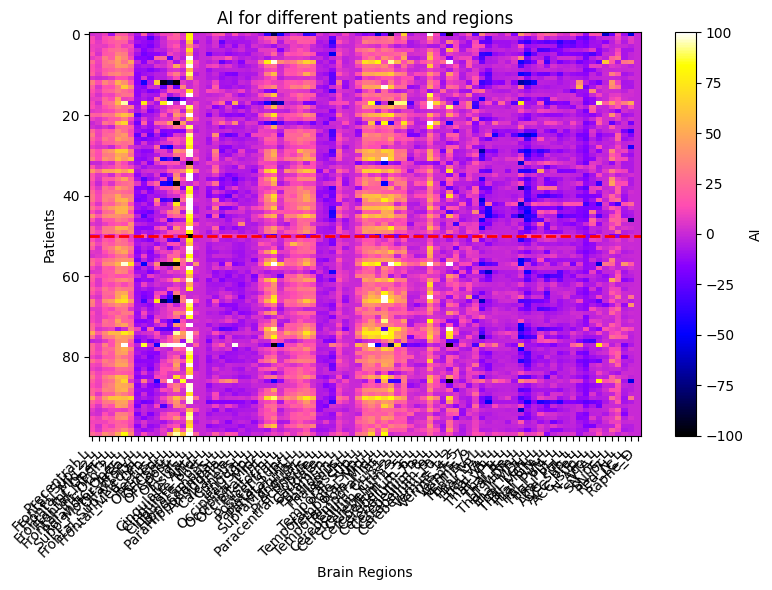

In [143]:
# Plot AI as a heatmap

plt.figure(figsize=(8, 6))
plt.imshow(relative_diff_ROI, aspect='auto', cmap='gnuplot2')
plt.colorbar(label='AI')
plt.title('AI for different patients and regions')
plt.xlabel('Brain Regions')
plt.ylabel('Patients')

plt.axhline(y=idx, color='r', linestyle='--', linewidth=2)

plt.xticks(ticks=np.arange(len(masks_title_L)), labels=masks_title_L, rotation=45, ha='right')
plt.tight_layout()
#plt.savefig(save_path + '/AI.png')  
plt.show()

### Calculating the AI of whole hemispheres

Firstly I want to check my understanding of how the mask is constructed. <br>
Odd values represent left regions and even values represent right regions. <br>
I think that the last two pairs are values 169 and 170. 171 and 255 values are not paired with anything.

In [63]:
# loading mask again, just to be sure
mask_image = nib.load(mask_path)

mask_image_data = mask_image.get_fdata()

In [74]:
left_region_mask = (mask_image_data[:, :, :] == 1)                # Left region mask
right_region_mask = (mask_image_data[:, :, :] == 2)               # Right region mask

In [75]:
print(np.unique(mask_image_data))

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.
  72.  73.  74.  75.  76.  77.  78.  79.  80.  83.  84.  85.  86.  87.
  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100. 101.
 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115.
 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128. 129.
 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143.
 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157.
 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170. 171.
 255.]


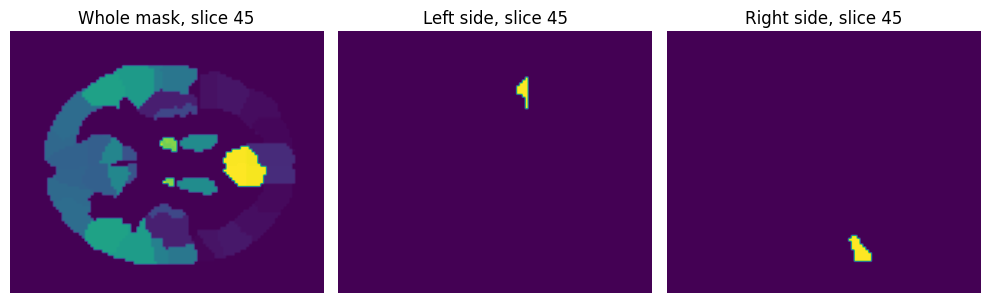

In [80]:
mask_slice_index = 45


fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(mask_image_data[:, :, mask_slice_index])
axs[0].set_title(f'Whole mask, slice {mask_slice_index}')
axs[0].axis('off')

axs[1].imshow(left_region_mask[:, :, mask_slice_index])
axs[1].set_title(f'Left side, slice {mask_slice_index}')
axs[1].axis('off')

axs[2].imshow(right_region_mask[:, :, mask_slice_index])
axs[2].set_title(f'Right side, slice {mask_slice_index}')
axs[2].axis('off')

plt.tight_layout()
plt.show()

If I want the whole left and right regions, I have to summ up all left and right region masks.

In [77]:
# initializing empty arrays
left_hemisphere_mask = np.zeros_like(mask_image_data, dtype=bool)              # Left hemisphere mask
right_hemisphere_mask = np.zeros_like(mask_image_data, dtype=bool)             # Right hemisphere mask

# Loop through the odd and even values to create the left and right hemisphere masks.
for i in range(1, 171):                                                   # Assuming regions are 1 to 170

    if i % 2 == 1:                                                        # Odd regions correspond to the left hemisphere
        left_hemisphere_mask |= (mask_image_data == i)

    else:                                                                      # Even regions correspond to the right hemisphere
        right_hemisphere_mask |= (mask_image_data == i)

In [79]:
print(left_hemisphere_mask.shape)
print(np.unique(left_hemisphere_mask))

(91, 109, 91)
[False  True]


Visualizing left and right region masks.

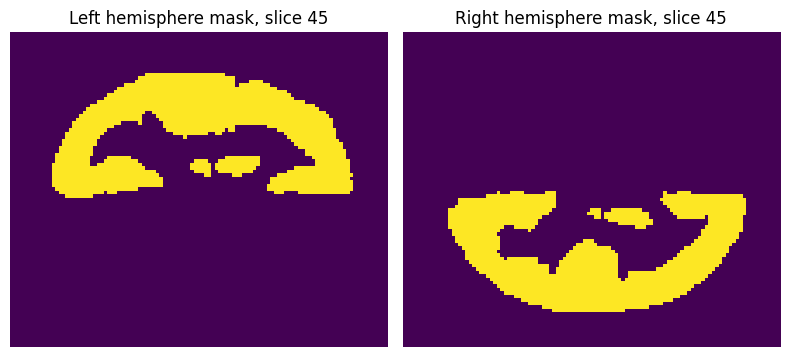

In [86]:
mask_slice_index = 45


fig, axs = plt.subplots(1, 2, figsize=(8, 5))

axs[0].imshow(left_hemisphere_mask[:, :, mask_slice_index])
axs[0].set_title(f'Left hemisphere mask, slice {mask_slice_index}')
axs[0].axis('off')

axs[1].imshow(right_hemisphere_mask[:, :, mask_slice_index])
axs[1].set_title(f'Right hemisphere mask, slice {mask_slice_index}')
axs[1].axis('off')

plt.tight_layout()
plt.show()

Now we can finally calculate the AI of the whole brain. 

In [134]:
# Number of patients in total
num_patients = patients_mat.shape[1]

# Split the number of patients into AD and NC groups
num_AD = num_patients // 2
num_NC = num_patients - num_AD                                        # If odd, NC will have 1 more

In [135]:
left_hemisphere_mask_flat = left_hemisphere_mask.flatten()   
right_hemisphere_mask_flat = right_hemisphere_mask.flatten()

In [136]:
print(left_hemisphere_mask_flat.shape)

(902629,)


In [138]:
# Initialize arrays to store AI for AD and NC patients
AI_AD = []
AI_NC = []

# Loop over each patient
for i in range(num_patients):                                                   # Iterate through each patient (each column)

    # Extract the intensity values for the left and right hemispheres using the flattened masks
    left_hemisphere_intensity = patients_mat[:, i] * left_hemisphere_mask_flat
    right_hemisphere_intensity = patients_mat[:, i] * right_hemisphere_mask_flat

    # Calculate the sum of intensity for the left and right hemispheres
    sum_left = np.sum(left_hemisphere_intensity)
    sum_right = np.sum(right_hemisphere_intensity)

    # Calculate the asymmetry index (AI) for this patient
    if sum_left + sum_right != 0:  # Avoid division by zero
        AI = 100 * (sum_right - sum_left) / (sum_right + sum_left)
    else:
        AI = 0                                                                   # Handle cases where the sum is zero

    # Append the AI to the respective group (AD or NC)
    if i < num_AD:                                                               # First half is AD
        AI_AD.append(AI)
    else:                                                                        # Second half is NC
        AI_NC.append(AI)


In [139]:
# Convert AI lists to numpy arrays
AI_AD = np.array(AI_AD)
AI_NC = np.array(AI_NC)

In [140]:
print(len(AI_AD))
print(len(AI_NC))

50
50


In [141]:
# Calculate the mean AI for AD and NC patients
mean_AI_AD = np.mean(AI_AD)
mean_AI_NC = np.mean(AI_NC)

# Calculate the standard deviation of AI for AD and NC patients
std_AI_AD = np.std(AI_AD)
std_AI_NC = np.std(AI_NC)

# Calculate the max and min of AI for both groups
max_AI_AD = np.max(AI_AD)
min_AI_AD = np.min(AI_AD)

max_AI_NC = np.max(AI_NC)
min_AI_NC = np.min(AI_NC)

# Output the results
print(f"Mean AI for AD patients: {mean_AI_AD} ± {std_AI_AD}")
print(f"Mean AI for NC patients: {mean_AI_NC} ± {std_AI_NC}")
print(f"Max and min for AD, max={max_AI_AD}, min={min_AI_AD}")
print(f"Max and min for NC, max={max_AI_NC}, min={min_AI_NC}")

Mean AI for AD patients: -7.5243002827513 ± 4.878577445629967
Mean AI for NC patients: -8.10445943737032 ± 5.163927265045836
Max and min for AD, max=0.902649885822896, min=-21.66532532029055
Max and min for NC, max=1.9172294410788342, min=-25.85751882529414


Plotting.

<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Crt\AppData\Local\Temp\ipykernel_4712\1341657192.py:23: SyntaxWarning: invalid escape sequence '\m'
  plt.savefig(save_path + '\mean_AI')


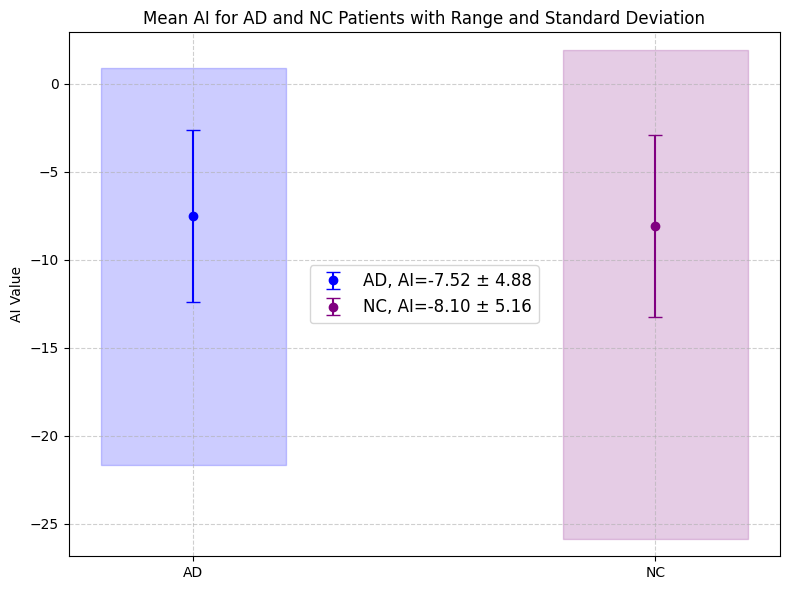

In [144]:
fig, ax = plt.subplots(figsize=(8, 6))

x_pos = [1, 1.5]

ax.fill_between([0.9, 1.1], min_AI_AD, max_AI_AD, color='blue', alpha=0.2)
ax.errorbar(1, mean_AI_AD, yerr=std_AI_AD, fmt='o', color='blue', label=f'AD, AI={mean_AI_AD:.2f} ± {std_AI_AD:.2f}', capsize=5)

ax.fill_between([1.4, 1.6], min_AI_NC, max_AI_NC, color='purple', alpha=0.2)
ax.errorbar(1.5, mean_AI_NC, yerr=std_AI_NC, fmt='o', color='purple', label=f'NC, AI={mean_AI_NC:.2f} ± {std_AI_NC:.2f}', capsize=5)

ax.set_xticks(x_pos)
ax.set_xticklabels(['AD', 'NC'])
ax.set_ylabel('AI Value')
ax.set_title('Mean AI for AD and NC Patients with Range and Standard Deviation')

ax.set_ylim([min(min_AI_AD, min_AI_NC) - 1, max(max_AI_AD, max_AI_NC) + 1])

ax.grid(True, linestyle='--', alpha=0.6)

plt.legend(loc='center', fontsize=12, bbox_to_anchor=(0.5, 0.5))

plt.tight_layout()
plt.savefig(save_path + '\mean_AI')
plt.show()

### AI index for a specific region
I want to look at the average AI of all patients for a few specific regions.